In [1]:
%matplotlib inline
import gc

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
from torchsummary import summary

from common_audio import *
from audio_dataset import *

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)

def clear_mem(print_mem=False):
    gc.collect()
    torch.cuda.empty_cache()
    if print_mem:
        print('total: ', torch.cuda.get_device_properties(0).total_memory/1e9)
        print('cached: ', torch.cuda.memory_cached()/1e9)
        print('allocated: ', torch.cuda.memory_allocated()/1e9)
        
NUM_SOURCES = 2


cuda


# Load Dataset

In [2]:
sr = 8000
duration = 5.0

voice_ds = FastAudioDataSet('datasets/voices.npy')
# noise_ds = FastAudioDataSet('datasets/noises.npy')

spectrogram_hw = audio_to_spectrogram(voice_ds.get_idxs([0]), sr)[0].shape

In [3]:
# utility
def to_torch(*arrays, device=device, dtype=dtype):
    if len(arrays) == 1:
        array = arrays[0]
        if isinstance(array, np.ndarray):
            array = torch.from_numpy(array)
        return array.to(device, dtype)
    ret = ()
    for array in arrays:
        ret += to_torch(array, device=device, dtype=dtype),
    return ret

def to_np(*arrays):
    if len(arrays) == 1:
        return arrays[0].detach().cpu().numpy()
    ret = ()
    for array in arrays:
        ret += to_np(array),
    return ret

# Model Definitions

In [4]:
def get_block_layer(c_in, c_out, kernel_size=3, padding=1):
    return nn.Sequential(nn.BatchNorm2d(c_in), 
                         nn.ReLU(), 
                         nn.Conv2d(c_in, c_out, kernel_size, padding=padding))
    

class NeuralTransform(nn.Module):
    def __init__(self, c_in, c_out, num_layers, gr):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        
        self.layers = nn.ModuleList()
        
        c_prev = c_in
        for layer_idx in range(num_layers-1):
            self.layers.append(get_block_layer(c_prev, gr))
            c_prev += gr
            
        self.final_layer = get_block_layer(c_prev, c_out)
        
        
    def forward(self, x):
        for layer in self.layers:
            x = torch.cat((x, layer(x)), axis=1)
        x = self.final_layer(x)
        return x
    
def get_down_sample_layer(c, kernel_size=(2,2), stride=(2,2)):
    return nn.Conv2d(c, c, kernel_size=kernel_size, stride=stride)
def get_up_sample_layer(c, kernel_size=(2,2), stride=(2,2)):
    return nn.ConvTranspose2d(c, c, kernel_size=kernel_size, stride=stride)

# frequency time convolutional neural network for generator
class FTCNNGenerator(nn.Module):
    def __init__(self, c_in, cs, c_out=None, num_layers_per_block=4, block_gr=24):
        super().__init__()
        
        if c_out is None:
            c_out = c_in
        
        rcs = list(reversed(cs))
        
        self.conv_first = nn.Conv2d(c_in, cs[0], kernel_size=1)
        self.conv_last = nn.Conv2d(rcs[-1], c_out, kernel_size=1)
        
        self.left = nn.ModuleList([NeuralTransform(c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(cs, cs[1:])])
        self.right = nn.ModuleList([NeuralTransform(2*c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(rcs, rcs[1:])])
        
        self.midnt = NeuralTransform(cs[-1], cs[-1], num_layers_per_block, block_gr)
        
        self.downs = nn.ModuleList([get_down_sample_layer(c) for c in cs[1:]])
        self.ups = nn.ModuleList([get_up_sample_layer(c) for c in rcs[:-1]])
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv_first(x)
        
        residuals = []
        shapes = []
        for nt, down in zip(self.left, self.downs):
            x = nt.forward(x)
            residuals.insert(0, x)
            shapes.insert(0, x.shape)
            x = down(x)
        
        x = self.midnt(x)
        
        for nt, up, residual, shape in zip(self.right, self.ups, residuals, shapes):
            x = up(x, output_size=shape)
            x = torch.cat((x, residual), dim=1)
            x = nt.forward(x)
        
        x = self.conv_last(x)
        return x
    

In [5]:
# frequency time convolutional neural network for discriminator
class FTCNNDiscrimminator(nn.Module):
    def __init__(self, c_in, cs, input_hw, fcs=[100, 10, 10, 1], num_layers_per_block=4, block_gr=24):
        super().__init__()
        
        self.conv_first = nn.Conv2d(c_in, cs[0], kernel_size=1)
        
        self.nts = nn.ModuleList([NeuralTransform(c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(cs, cs[1:])])
        self.dss = nn.ModuleList([get_down_sample_layer(c_out) for c_out in cs[1:]])
        
        h = input_hw[0] // (2**len(self.dss))
        w = input_hw[1] // (2**len(self.dss))
    
        self.fc1d1 = cs[-1]*h*w
            
        fcs.insert(0, self.fc1d1)
        self.fcs = nn.ModuleList([nn.Linear(d1, d2) for d1, d2 in zip(fcs, fcs[1:])])
        
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv_first(x)
        
        for nt, down in zip(self.nts, self.dss):
            x = nt.forward(x)
            x = down(x)
        x = x.view(-1, self.fc1d1)
        
        for fc in self.fcs[:-1]:
            x = fc(x)
            x = torch.relu(x)
        
        x = self.fcs[-1](x)
        x = torch.sigmoid(x)
        return x[:, 0]


In [6]:
model_g = FTCNNGenerator(2, [6, 6, 6, 6, 6], 
                         num_layers_per_block=4, block_gr=24).to(device, dtype)
# model_g = torch.load('models/ftnn_naive_epochs300.pth')
summary(model_g, input_size=(2,)+spectrogram_hw)

model_d = FTCNNDiscrimminator(2, [6, 6, 6, 6, 6], input_hw = spectrogram_hw, 
                              num_layers_per_block=4, block_gr=24).to(device, dtype)
summary(model_d, input_size=(2,)+spectrogram_hw)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 129, 626]              18
       BatchNorm2d-2          [-1, 6, 129, 626]              12
              ReLU-3          [-1, 6, 129, 626]               0
            Conv2d-4         [-1, 24, 129, 626]           1,320
       BatchNorm2d-5         [-1, 30, 129, 626]              60
              ReLU-6         [-1, 30, 129, 626]               0
            Conv2d-7         [-1, 24, 129, 626]           6,504
       BatchNorm2d-8         [-1, 54, 129, 626]             108
              ReLU-9         [-1, 54, 129, 626]               0
           Conv2d-10         [-1, 24, 129, 626]          11,688
      BatchNorm2d-11         [-1, 78, 129, 626]             156
             ReLU-12         [-1, 78, 129, 626]               0
           Conv2d-13          [-1, 6, 129, 626]           4,218
           Conv2d-14           [-1, 6, 

# Manual Method
Seperating the frequency manually from spectrogram

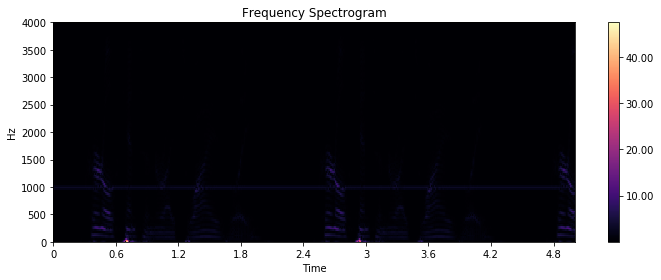

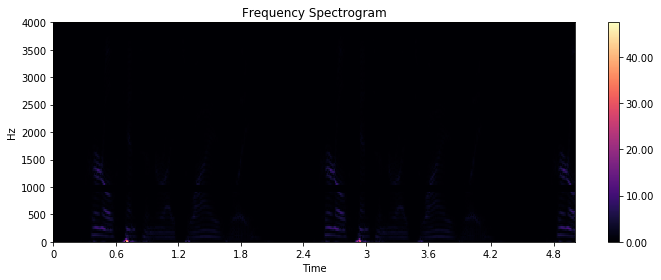

In [7]:
y_voice = voice_ds.get_idxs([0])[0]
y_tone = generate_tone(sr, duration, np.array([1000]), np.array([0.05]))[0]

y = y_voice + y_tone
play_audio(y, sr)
spectrogram = audio_to_spectrogram([y], sr)[0]

show_spectrogram(np.abs(spectrogram), sr)
plt.show()
play_audio(spectrogram_to_audio([spectrogram], sr)[0], sr)

spectrogram[30:34, :] = 0

show_spectrogram(np.abs(spectrogram), sr)
plt.show()
play_audio(spectrogram_to_audio([spectrogram], sr)[0], sr)


# Base Method

Make a neural network to just take out the tone

In [8]:
def generate_sources(batch_size):
    s1 = voice_ds.get_next(batch_size)
    s2 = generate_tone(sr, duration, np.linspace(750, 2500, batch_size), 0.05*np.ones(batch_size))
#     s2 = 0.1 * noise_ds.get_next(batch_size)
#     s3 = generate_tone(sr, duration, np.linspace(750, 2500, batch_size), 0.05*np.ones(batch_size))
    ss = (s1, s2,)
    return np.stack(ss, axis=0)

def generate_nn_io(sources=None, batch_size=None):
    if sources is None:
        sources = generate_sources(batch_size)
    
    X_batch = sources.sum(axis=0) # input is the mixture
    X_batch = complex_to_channels(audio_to_spectrogram(X_batch, sr))
    
    Y_batch = []
    for source_idx in range(NUM_SOURCES-1): # output is all but the noise
        source = sources[source_idx]
        source = complex_to_channels(audio_to_spectrogram(source, sr))
        Y_batch.append(source)
        
    Y_batch = np.concatenate(Y_batch, axis=-3)
    return X_batch, Y_batch
    

mse = nn.MSELoss()
bce = nn.BCELoss()

def generator_loss_function_base(Y_batch_pred, Y_batch):
    # normal MSE loss for now
    return mse(Y_batch_pred, Y_batch)

In [9]:
# create test set
test_set_size = 10

voice_ds.reset_next()
# noise_ds.reset_next()
test_sources = generate_sources(test_set_size)
X_test, Y_test = generate_nn_io(test_sources)

print(X_test.shape)
print(Y_test.shape)

(10, 2, 129, 626)
(10, 2, 129, 626)


In [10]:
def show_test_example(model_g, X_test, Y_test, show_idx=0):
    X_test = X_test[show_idx:show_idx+1]
    Y_test = Y_test[show_idx:show_idx+1]
    with torch.no_grad():
        Y_test_pred = to_np(model_g.forward(to_torch(X_test)))
    
    X_test = channels_to_complex(X_test)
    Y_test = channels_to_complex(Y_test)
    Y_test_pred = channels_to_complex(Y_test_pred)
    
    print("Input: ")
    show_complete_spectrogram(X_test[0], sr)
    plt.show()
    play_audio(spectrogram_to_audio(X_test, sr)[0], sr)

    # show_complete_spectrogram(Y_test[0], sr)
    # plt.show()
    # play_audio(spectrogram_to_audio(Y_test, sr)[0], sr)

    print("Output: ")
    show_complete_spectrogram(Y_test_pred[0], sr)
    plt.show()
    play_audio(spectrogram_to_audio(Y_test_pred, sr)[0], sr)

Test Loss:  0.32562991976737976
Input: 


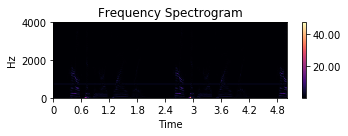

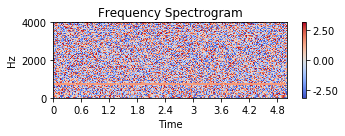

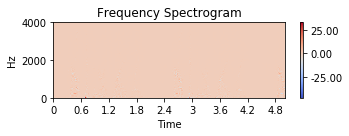

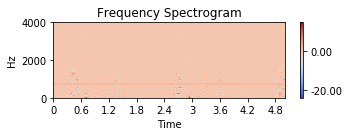

Output: 


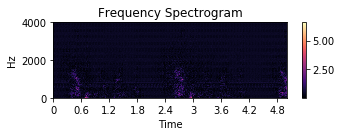

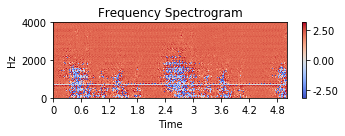

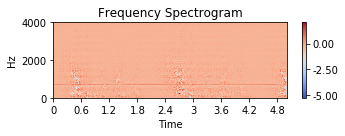

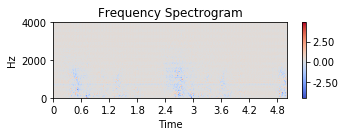

In [11]:
print('Test Loss: ', generator_loss_function_base(model_g.forward(to_torch(X_test)), to_torch(Y_test)).item())
show_test_example(model_g, X_test, Y_test, show_idx=0)

In [12]:
clear_mem(True)

total:  11.996954624
cached:  0.006291456
allocated:  0.002249728



CPU times: user 5min 10s, sys: 1min 53s, total: 7min 4s
Wall time: 7min 5s


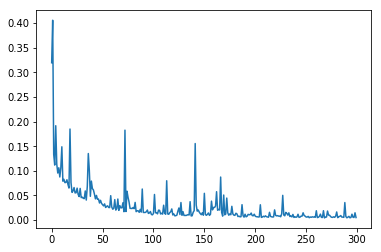

In [13]:
%%time
model_g = model_g.train()

batch_size = 10
losses = []

batch_pbar = tqdm(range(300), desc='Batches')

for batch_idx in batch_pbar:
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)

    model_g.opt.zero_grad()
    Y_batch_pred = model_g.forward(X_batch)
    loss = generator_loss_function_base(Y_batch_pred, Y_batch)
    loss.backward()
    model_g.opt.step()
    
    loss = loss.item()
    losses.append(loss)
    batch_pbar.set_postfix({'Loss':loss})
    
plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, losses

model_g = model_g.eval()

In [14]:
clear_mem(True)

total:  11.996954624
cached:  0.01048576
allocated:  0.005246464


Test Loss:  0.00611319812014699
Input: 


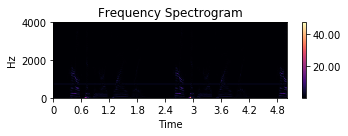

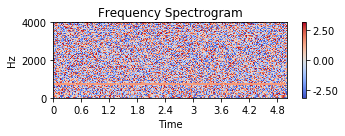

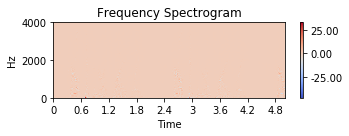

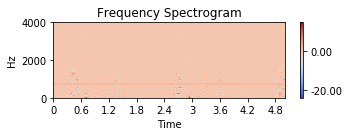

Output: 


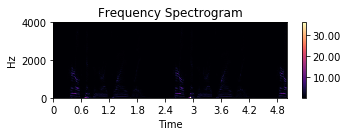

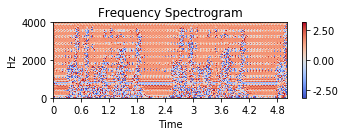

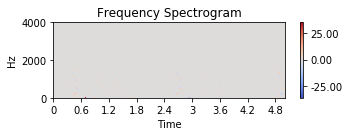

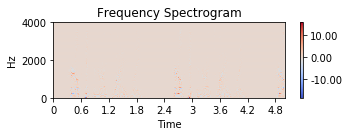

In [15]:
print('Test Loss: ', generator_loss_function_base(model_g.forward(to_torch(X_test)), to_torch(Y_test)).item())
show_test_example(model_g, X_test, Y_test, show_idx=0)

Input: 


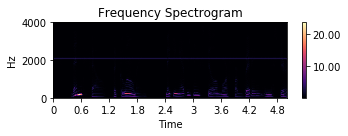

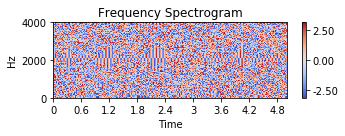

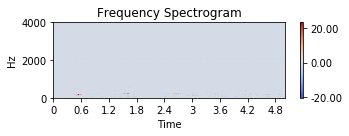

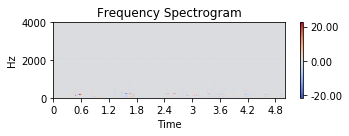

Output: 


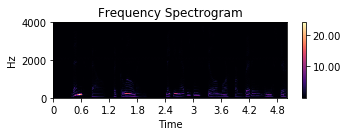

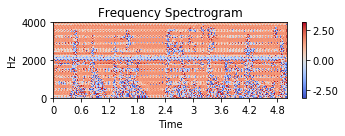

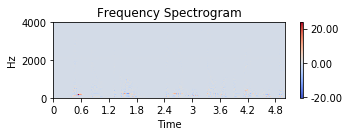

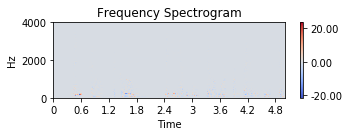

In [16]:
show_test_example(model_g, X_test, Y_test, show_idx=7)

In [17]:
torch.save(model_g, f'models/ftnn_naive_med_epochs{300}.pth')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FTCNNGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NeuralTransform. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Our Method

Generator-Discriminator setup (without GAN)

In [18]:
def discriminator_loss_function_base(real_out, fake_out):
    return bce(real_out, torch.ones_like(real_out)) + bce(fake_out, torch.zeros_like(fake_out))

def generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d):
    Yp_batch = X_batch - Y_batch # the noise
    Yp_batch_pred = X_batch - Y_batch_pred
    
    d_Y_batch_pred = model_d.forward(Y_batch_pred)
    d_Yp_batch_pred = model_d.forward(Yp_batch_pred)
    
#     loss1 = mse_crit(Y_batch_pred, Y_batch)
#     loss2 = mse_crit(Yp_batch, Yp_batch_pred) # EXACT same the previous
    loss1 = 0.
    
    loss3 = bce(d_Y_batch_pred, torch.ones_like(d_Y_batch_pred))
    loss4 = bce(d_Yp_batch_pred, torch.zeros_like(d_Yp_batch_pred))
    
    total_loss = loss1+loss3+loss4
    
    return total_loss

### Training Discriminator

In [19]:
# create test set
test_set_size = 10

voice_ds.reset_next()
X_test, Y_test = generate_nn_io(batch_size=test_set_size)

print(X_test.shape)
print(Y_test.shape)

(10, 2, 129, 626)
(10, 2, 129, 626)


In [20]:
with torch.no_grad():
    Y_test_pred = model_g.forward(to_torch(X_test))

    fake_out = model_d.forward(Y_test_pred)
    real_out = model_d.forward(to_torch(Y_test))

    test_loss = discriminator_loss_function_base(real_out, fake_out).item()
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  1.3864991664886475
Accuracy:  0.5


In [21]:
clear_mem(True)

total:  11.996954624
cached:  0.03145728
allocated:  0.011707904


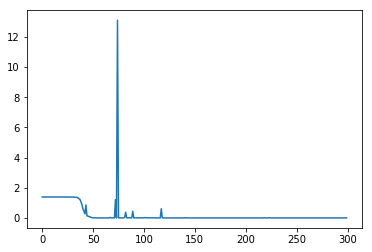

In [22]:
# %%time
model_d = model_d.train()

losses = []
batch_size = 10

batch_pbar = tqdm(range(300), desc='Batches')

for epoch in batch_pbar:
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)
    
    with torch.no_grad():
        Y_batch_pred = model_g(X_batch)
    
    model_d.opt.zero_grad()
    real_out = model_d(Y_batch)
    fake_out = model_d(Y_batch_pred)
    loss = discriminator_loss_function_base(real_out, fake_out)
    loss.backward()
    model_d.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    batch_pbar.set_postfix({'Loss':loss})
        
plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, real_out, fake_out, losses


model_d = model_d.eval()

In [23]:
clear_mem(True)


total:  11.996954624
cached:  0.03145728
allocated:  0.015219712


In [24]:
with torch.no_grad():
    Y_test_pred = model_g.forward(to_torch(X_test))

    fake_out = model_d.forward(Y_test_pred)
    real_out = model_d.forward(to_torch(Y_test))

    test_loss = discriminator_loss_function_base(real_out, fake_out)
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  tensor(2.3175e-05, device='cuda:0')
Accuracy:  1.0


In [66]:
torch.save(model_d, 'models/disc_model.pth')

# GAN Training

In [25]:
clear_mem(True)



total:  11.996954624
cached:  0.03145728
allocated:  0.01561344


In [26]:
# %%time
model_d = model_d.train()
model_g = model_g.train()


g_losses = []
d_losses = []

batch_pbar = tqdm(range(300), desc='Batches')

batch_size = 10
for epoch in batch_pbar:
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)
    

    # update discriminator
    model_d.opt.zero_grad()
    Y_batch_pred = model_g(X_batch)
    real_out = model_d(Y_batch)
    fake_out = model_d(Y_batch_pred)
    loss = discriminator_loss_function_base(real_out, fake_out)
    loss.backward()
    model_d.opt.step()
    
    loss = loss.item()
    d_losses.append(loss)
    batch_pbar.set_postfix({'D Loss':loss})
    
    # update generator
    model_d.opt.zero_grad()
    model_g.opt.zero_grad()
    
    Y_batch_pred = model_g(X_batch)
    loss = generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d)
    loss.backward()
    model_g.opt.step()
    
    loss = loss.item()
    g_losses.append(loss)
    batch_pbar.set_postfix({'G Loss':loss})
    
del X_batch, Y_batch, Y_batch_pred, loss
    
plt.plot(np.arange(len(losses)), losses)


model_d = model_d.eval()
model_g = model_g.eval()

NameError: name 'losses' is not defined

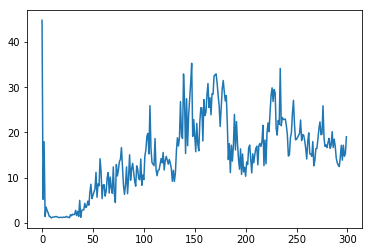

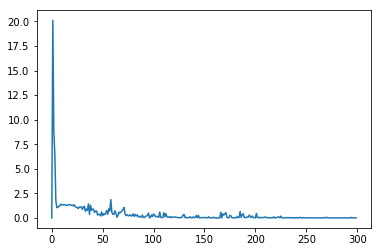

In [27]:
plt.plot(np.arange(len(g_losses)), g_losses)
plt.show()

plt.plot(np.arange(len(d_losses)), d_losses)
plt.show()



In [ ]:
clear_mem(True)

In [ ]:
show_test_example(model_g, X_test, Y_test, show_idx=0)